In [0]:
import pandas as pd
import numpy as np

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/m5_data.zip", 'r')
zip_ref.extractall()
zip_ref.close()

# Start

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
def read_data():
    print('Reading files...')
    calendar = pd.read_csv('calendar.csv')
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv('sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_validation = pd.read_csv('sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    submission = pd.read_csv('sample_submission.csv')
    return calendar, sell_prices, sales_train_validation, submission

calendar, sell_prices, sales_train_validation, submission = read_data()

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 169.63 Mb (18.7% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns


In [0]:
columns_list = ['d_' + str(i) for i in np.arange(1914, 1970, 1)]
sub_df = dict()

for column in columns_list:
  sub_df[column] = np.zeros(len(sales_train_validation))

sub_df = pd.DataFrame(sub_df)

In [0]:
sales_train_validation = pd.concat([sales_train_validation, sub_df], axis=1)
sales_train_validation.shape

(30490, 1975)

In [0]:
sales_train_validation_melt = pd.melt(sales_train_validation, 
                                      id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                                      var_name='day', 
                                      value_name='demand')

# Melting dataframe, extracting CA_1

In [0]:
sales_CA_1 = sales_train_validation_melt[sales_train_validation_melt.store_id == "CA_1"]
new_CA_1 = pd.merge(sales_CA_1, calendar, left_on="day", right_on="d", how="left")
new_CA_1 = pd.merge(new_CA_1, sell_prices, left_on=["store_id", "item_id", "wm_yr_wk"],right_on=["store_id", "item_id", "wm_yr_wk"], how="left")
new_CA_1["day_int"] = new_CA_1.day.apply(lambda x: int(x.split("_")[-1])) # day_1 -> 1

In [0]:
sales_CA_1 # all info about all items in CA_1

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...,...
58299924,FOODS_3_823_CA_1_validation,FOODS_3_823,FOODS_3,FOODS,CA_1,CA,d_1913,1
58299925,FOODS_3_824_CA_1_validation,FOODS_3_824,FOODS_3,FOODS,CA_1,CA,d_1913,0
58299926,FOODS_3_825_CA_1_validation,FOODS_3_825,FOODS_3,FOODS,CA_1,CA,d_1913,2
58299927,FOODS_3_826_CA_1_validation,FOODS_3_826,FOODS_3,FOODS,CA_1,CA,d_1913,0


In [0]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [0]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [0]:
new_CA_1.head() # merged with calendar and price to get more info

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,day_int
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1


In [0]:
day_sum = new_CA_1.groupby("day_int")[["sell_price", "demand"]].agg("sum").reset_index()

In [0]:
day_sum # the price and total sales in CA_1

,day_int,sell_price,demand
0,1,4913.61,4337
1,2,4913.61,4155
2,3,4913.61,2816
3,4,4913.61,3051
4,5,4913.61,2630
...,...,...,...
1908,1909,13691.54,3722
1909,1910,13691.54,3709
1910,1911,13691.54,4387
1911,1912,13691.33,5577


In [0]:
new_CA_1[new_CA_1['day_int'] == 1] # look at the first day

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,day_int
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,FOODS_3_823_CA_1_validation,FOODS_3_823,FOODS_3,FOODS,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1
3045,FOODS_3_824_CA_1_validation,FOODS_3_824,FOODS_3,FOODS,CA_1,CA,d_1,1,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,2.47,1
3046,FOODS_3_825_CA_1_validation,FOODS_3_825,FOODS_3,FOODS,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1
3047,FOODS_3_826_CA_1_validation,FOODS_3_826,FOODS_3,FOODS,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1


In [0]:
import matplotlib.pyplot as plt

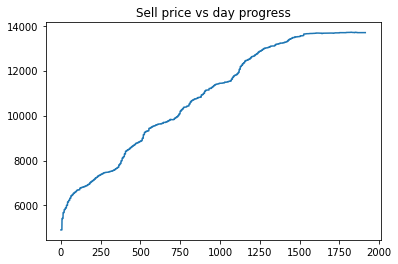

In [0]:
plt.plot(day_sum['day_int'], day_sum['sell_price'])
plt.title("Sell price vs day progress")
plt.show()

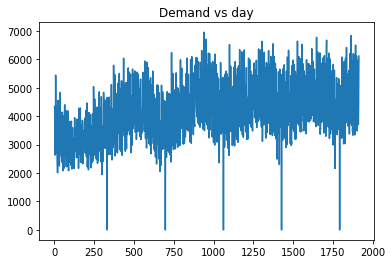

In [0]:
plt.plot(day_sum['day_int'], day_sum['demand'])
plt.title("Demand vs day")
plt.show()

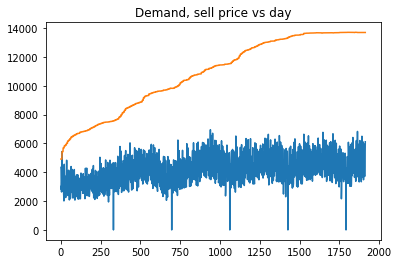

In [0]:
plt.plot(day_sum['day_int'], day_sum['demand'])
plt.plot(day_sum['day_int'], day_sum['sell_price'])
plt.title("Demand, sell price vs day")
plt.show()

# Check how many null values in the price data

In [0]:
# For each day we count_nonzeros over products sell_price and demand

day_sum = new_CA_1.groupby("day_int")[["demand","event_name_1" ]].agg({"demand": np.count_nonzero, "event_name_1": "first"}).reset_index()
def count_nulls(series):
    return len(series) - series.count()

count_null = new_CA_1.groupby("day_int")["sell_price"].agg(count_nulls).reset_index()

In [0]:
count_null

,day_int,sell_price
0,1,1845.0
1,2,1845.0
2,3,1845.0
3,4,1845.0
4,5,1845.0
...,...,...
1908,1909,0.0
1909,1910,0.0
1910,1911,0.0
1911,1912,0.0


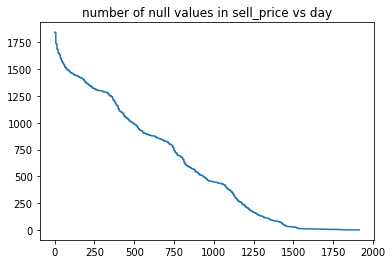

In [0]:
plt.plot(count_null['day_int'], count_null['sell_price'])
plt.title("number of null values in sell_price vs day")
plt.show()

In [0]:
3049 - new_CA_1[new_CA_1['day_int'] == 1900]['sell_price'].count()

0

In [0]:
del new_CA_1, count_null, sales_CA_1

# Looking at the demand of each event average

In [0]:
day_sum # added the first event to day_sum

,day_int,demand,event_name_1
0,1,837,NaN
1,2,778,NaN
2,3,681,NaN
3,4,700,NaN
4,5,658,NaN
...,...,...,...
1908,1909,1345,NaN
1909,1910,1287,NaN
1910,1911,1478,NaN
1911,1912,1679,NaN


# Melting the whole training set

In [0]:
del sales_train_validation

In [0]:
train_melt = pd.merge(sales_train_validation_melt, calendar, left_on="day", right_on="d", how="left")
train_melt = pd.merge(train_melt, sell_prices, left_on=["store_id", "item_id", "wm_yr_wk"],right_on=["store_id", "item_id", "wm_yr_wk"], how="left")
train_melt["day_int"] = train_melt.day.apply(lambda x: int(x.split("_")[-1]))
# train_melt

In [0]:
train_melt.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'day',
       'demand', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'day_int'],
      dtype='object')

In [0]:
del sales_train_validation_melt

In [0]:
train_melt = reduce_mem_usage(train_melt)

Mem. usage decreased to 7843.17 Mb (7.8% reduction)


In [0]:
train_melt.to_csv("train_melt.csv", index=False)

# Explore the total demand in a day and relation to having event

In [0]:
demand_daily = train_melt.groupby(["day_int"])["demand"].agg(sum).reset_index()

In [0]:
demand_daily

,day_int,demand
0,1,32631.0
1,2,31749.0
2,3,23783.0
3,4,25412.0
4,5,19146.0
...,...,...
1908,1909,35343.0
1909,1910,35033.0
1910,1911,40517.0
1911,1912,48962.0


In [0]:
calendar['day_int'] = calendar['d'].apply(lambda x: int(x.split("_")[-1])) # day_1 -> 1
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_int
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,2
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,3
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,4
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1,1965
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0,1966
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0,1967
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0,1968


In [0]:
demand_event = pd.merge(demand_daily, calendar[['day_int', 'event_name_1']], on="day_int")
demand_event['has_event'] = demand_event['event_name_1'].apply(lambda x: int(str(x) != str(demand_event.loc[0, 'event_name_1'])))
demand_event

,day_int,demand,event_name_1,has_event
0,1,32631.0,NaN,0
1,2,31749.0,NaN,0
2,3,23783.0,NaN,0
3,4,25412.0,NaN,0
4,5,19146.0,NaN,0
...,...,...,...,...
1908,1909,35343.0,NaN,0
1909,1910,35033.0,NaN,0
1910,1911,40517.0,NaN,0
1911,1912,48962.0,NaN,0


In [0]:
demand_event.groupby('event_name_1')['demand'].agg(np.mean)

event_name_1
Chanukah End           33426.800000
Christmas                 15.600000
Cinco De Mayo          32823.500000
ColumbusDay            35164.800000
Easter                 39517.600000
Eid al-Fitr            35267.600000
EidAlAdha              34504.000000
Father's day           36562.000000
Halloween              30059.400000
IndependenceDay        33710.800000
LaborDay               42154.600000
LentStart              30727.000000
LentWeek2              29747.000000
MartinLutherKingDay    33378.600000
MemorialDay            32699.600000
Mother's day           34211.400000
NBAFinalsEnd           33564.200000
NBAFinalsStart         31874.400000
NewYear                25768.400000
OrthodoxChristmas      33344.200000
OrthodoxEaster         38277.000000
Pesach End             33450.200000
PresidentsDay          34446.333333
Purim End              35957.000000
Ramadan starts         34779.600000
StPatricksDay          33459.666667
SuperBowl              40924.000000
Thanksgiving   

In [0]:
demand_event.groupby('has_event')['demand'].agg(np.mean)

has_event
0    34489.207504
1    32655.149351
Name: demand, dtype: float64

In [0]:
demand_event.groupby('has_event')['demand'].agg(np.std)

has_event
0    7133.701801
1    9300.905832
Name: demand, dtype: float64

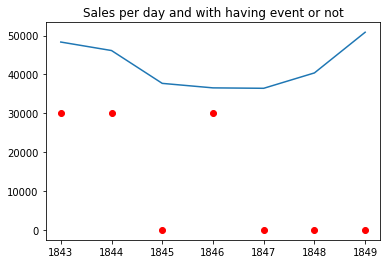

In [0]:
first_year = demand_event[1842:1849]

plt.plot(first_year["day_int"], first_year["demand"])
plt.scatter(first_year["day_int"], first_year["has_event"] * 30000, color="red")
plt.title("Sales per day and with having event or not")
plt.show()

# Explore the relation with the event type

In [0]:
demand_daily

,day_int,demand
0,1,32631.0
1,2,31749.0
2,3,23783.0
3,4,25412.0
4,5,19146.0
...,...,...
1908,1909,35343.0
1909,1910,35033.0
1910,1911,40517.0
1911,1912,48962.0


In [0]:
demand_event_type = pd.merge(demand_daily, calendar[['day_int', 'event_type_1']], on="day_int")
demand_event_type

,day_int,demand,event_type_1
0,1,32631.0,NaN
1,2,31749.0,NaN
2,3,23783.0,NaN
3,4,25412.0,NaN
4,5,19146.0,NaN
...,...,...,...
1908,1909,35343.0,NaN
1909,1910,35033.0,NaN
1910,1911,40517.0,NaN
1911,1912,48962.0,NaN


In [0]:
demand_event_type[-365:].groupby('event_type_1')['demand'].agg(np.mean)

event_type_1
Cultural     40997.285714
National     33743.400000
Religious    37052.375000
Sporting     37837.666667
Name: demand, dtype: float64

In [0]:
demand_event[-365:].groupby('has_event')['demand'].agg(np.mean) # compare the mean of demand of each event type to no event days

has_event
0    39628.436202
1    36940.964286
Name: demand, dtype: float64

In [0]:
demand_event_type[-365:].groupby('event_type_1').count()

,day_int,demand
event_type_1,,
Cultural,7,7
National,10,10
Religious,8,8
Sporting,3,3


In [0]:
demand_event_type_ly = demand_event_type[-365:]

sporting = demand_event_type_ly[demand_event_type_ly['event_type_1'] == 'Sporting'][['demand', 'event_type_1']].reset_index().drop(columns = 'index')
religious = demand_event_type_ly[demand_event_type_ly['event_type_1'] == 'Religious'][['demand', 'event_type_1']].reset_index().drop(columns = 'index')
national = demand_event_type_ly[demand_event_type_ly['event_type_1'] == 'National'][['demand', 'event_type_1']].reset_index().drop(columns = 'index')
cultural = demand_event_type_ly[demand_event_type_ly['event_type_1'] == 'Cultural'][['demand', 'event_type_1']].reset_index().drop(columns = 'index')

pd.concat([sporting, religious, national, cultural], axis=1)

,demand,event_type_1,demand,event_type_1,demand,event_type_1,demand,event_type_1
0,34922.0,Sporting,34425.0,Religious,37817.0,National,35089.0,Cultural
1,31698.0,Sporting,45660.0,Religious,37489.0,National,38030.0,Cultural
2,46893.0,Sporting,32967.0,Religious,45762.0,National,41413.0,Cultural
3,NaN,NaN,37522.0,Religious,42240.0,National,42743.0,Cultural
4,NaN,NaN,35944.0,Religious,33338.0,National,48337.0,Cultural
5,NaN,NaN,39353.0,Religious,23631.0,National,35009.0,Cultural
6,NaN,NaN,36545.0,Religious,14.0,National,46360.0,Cultural
7,NaN,NaN,34003.0,Religious,32651.0,National,NaN,NaN
8,NaN,NaN,NaN,NaN,38340.0,National,NaN,NaN
9,NaN,NaN,NaN,NaN,46152.0,National,NaN,NaN


In [0]:
demand_event_type[demand_event_type['event_type_1'] == 'Sporting']

,day_int,demand,event_type_1
8,9,32736.0,Sporting
122,123,19555.0,Sporting
134,135,31094.0,Sporting
372,373,40075.0,Sporting
500,501,35074.0,Sporting
509,510,30764.0,Sporting
736,737,41558.0,Sporting
859,860,34166.0,Sporting
873,874,31771.0,Sporting
1100,1101,43897.0,Sporting


# Explore the relation with the day in a week

In [0]:
train_melt.groupby("weekday")["demand"].agg(np.mean)

weekday
Friday       1.122531
Monday       1.077500
Saturday     1.362640
Sunday       1.348968
Thursday     0.990653
Tuesday      0.996024
Wednesday    0.984258
Name: demand, dtype: float64

In [0]:
train_melt.groupby("weekday")["demand"].agg(np.std)

weekday
Friday       3.882051
Monday       3.656730
Saturday     4.593460
Sunday       4.508957
Thursday     3.429051
Tuesday      3.408766
Wednesday    3.398607
Name: demand, dtype: float64

In [0]:
demand_event["day_int"]

0          1
1          2
2          3
3          4
4          5
        ... 
1908    1909
1909    1910
1910    1911
1911    1912
1912    1913
Name: day_int, Length: 1913, dtype: int64

In [0]:
mon = train_melt[train_melt['wday'] == 3]
tue = train_melt[train_melt['wday'] == 4]
wed = train_melt[train_melt['wday'] == 5]
thu = train_melt[train_melt['wday'] == 6]
fri = train_melt[train_melt['wday'] == 7]
sat = train_melt[train_melt['wday'] == 1]
sun = train_melt[train_melt['wday'] == 2]

In [0]:
mon_demand = mon.groupby(["day_int"])["demand"].agg(sum).reset_index()['demand']
tue_demand = tue.groupby(["day_int"])["demand"].agg(sum).reset_index()['demand']
wed_demand = wed.groupby(["day_int"])["demand"].agg(sum).reset_index()['demand']
thu_demand = thu.groupby(["day_int"])["demand"].agg(sum).reset_index()['demand']
fri_demand = fri.groupby(["day_int"])["demand"].agg(sum).reset_index()['demand']
sat_demand = sat.groupby(["day_int"])["demand"].agg(sum).reset_index()['demand']
sun_demand = sun.groupby(["day_int"])["demand"].agg(sum).reset_index()['demand']


# Total demand of the last year according the weeksday

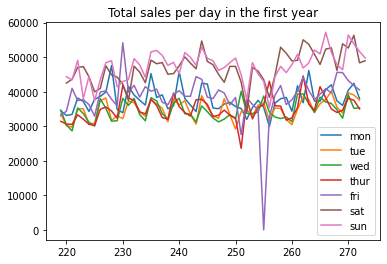

In [0]:
demand_wd = [mon_demand, tue_demand, wed_demand, thu_demand, fri_demand, sat_demand, sun_demand]
labels = ['mon', 'tue', 'wed', 'thur', 'fri', 'sat', 'sun']


for demand, label in zip(demand_wd, labels):
    plt.plot(demand[-54:], label=label)
    
plt.legend()
plt.title("Total sales per day in the first year")
plt.show()

# Total demand of the first year according the weeksday

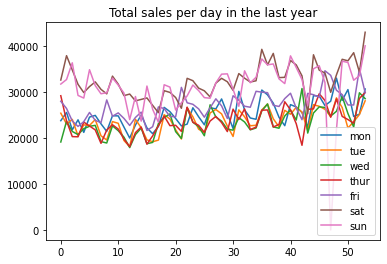

In [0]:
demand_wd = [mon_demand, tue_demand, wed_demand, thu_demand, fri_demand, sat_demand, sun_demand]
labels = ['mon', 'tue', 'wed', 'thur', 'fri', 'sat', 'sun']


for demand, label in zip(demand_wd, labels):
    plt.plot(demand[:54], label=label)
    
plt.legend()
plt.title("Total sales per day in the last year")
plt.show()

In [0]:
del mon, tue, wed, thu, fri, sat, sun, demand_event, demand_event_type, demand_event_type_ly

# Selecting features

In [0]:
# train_melt.head()

In [0]:
train_melt.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'day',
       'demand', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'day_int'],
      dtype='object')

In [0]:
features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'wday', 'month',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'demand', 'day_int']

In [0]:
train_melt['date'] = pd.to_datetime(train_melt['date'])

In [0]:
train_melt_2015 = train_melt[train_melt['date'] > pd.to_datetime('2015-05-19')]

In [0]:
train_melt_2015.to_csv("train_melt_2015.csv", index=False)

# Setting up training data

In [0]:
train_melt_2015 = pd.read_csv("/content/gdrive/My Drive/train_melt_2015.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
train_melt_2015 = pd.read_csv("train_melt_2015.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
X = train_melt_2015[features]

print(X.shape)

(12104530, 17)


In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

In [0]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12104530 entries, 0 to 12104529
Data columns (total 17 columns):
 #   Column        Dtype  
---  ------        -----  
 0   item_id       object 
 1   dept_id       object 
 2   cat_id        object 
 3   store_id      object 
 4   state_id      object 
 5   wday          int64  
 6   month         int64  
 7   event_name_1  object 
 8   event_type_1  object 
 9   event_name_2  object 
 10  event_type_2  object 
 11  snap_CA       int64  
 12  snap_TX       int64  
 13  snap_WI       int64  
 14  sell_price    float64
 15  demand        float64
 16  day_int       int64  
dtypes: float64(2), int64(6), object(9)
memory usage: 1.5+ GB


In [0]:
X.iloc[0, :]

item_id         HOBBIES_1_001
dept_id             HOBBIES_1
cat_id                HOBBIES
store_id                 CA_1
state_id                   CA
wday                        5
month                       5
event_name_1              NaN
event_type_1              NaN
event_name_2              NaN
event_type_2              NaN
snap_CA                     0
snap_TX                     0
snap_WI                     0
sell_price               8.26
demand                      0
day_int                  1573
Name: 0, dtype: object

## Converting Categorical data

In [0]:
X['item_id_int'] = X['item_id'].apply(lambda x: x[-3:]).astype(int)
X['dept_id'] = X['dept_id'].apply(lambda x: x[-1]).astype(int)
X['store_id'] = X['store_id'].apply(lambda x: x[-1]).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [0]:
X['event_name_1'] = le.fit_transform(X['event_name_1'].astype(str)) + 1
X['event_type_1'] = le.fit_transform(X['event_type_1'].astype(str)) + 1
X['event_name_2'] = le.fit_transform(X['event_name_2'].astype(str)) + 1
X['event_type_2'] = le.fit_transform(X['event_type_2'].astype(str)) + 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [0]:
X['cat_id'] = le.fit_transform(X['cat_id'].astype(str)) + 1
X['state_id'] = le.fit_transform(X['state_id'].astype(str)) + 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12104530 entries, 0 to 12104529
Data columns (total 18 columns):
 #   Column        Dtype  
---  ------        -----  
 0   item_id       object 
 1   dept_id       int64  
 2   cat_id        int64  
 3   store_id      int64  
 4   state_id      int64  
 5   wday          int64  
 6   month         int64  
 7   event_name_1  int64  
 8   event_type_1  int64  
 9   event_name_2  int64  
 10  event_type_2  int64  
 11  snap_CA       int64  
 12  snap_TX       int64  
 13  snap_WI       int64  
 14  sell_price    float64
 15  demand        float64
 16  day_int       int64  
 17  item_id_int   int64  
dtypes: float64(2), int64(15), object(1)
memory usage: 1.6+ GB


## Tackling null value in price

In [0]:
X['sell_price'].isnull().sum()

22453

In [0]:
X['sell_price'].fillna(0, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [0]:
X['sell_price'].isnull().sum()

0

In [0]:
1913 - 30

1883

In [0]:
X['day_int'].describe()

count    1.210453e+07
mean     1.771000e+03
std      1.146037e+02
min      1.573000e+03
25%      1.672000e+03
50%      1.771000e+03
75%      1.870000e+03
max      1.969000e+03
Name: day_int, dtype: float64

In [0]:
X.iloc[0, :]

item_id         HOBBIES_1_001
dept_id                     1
cat_id                      2
store_id                    1
state_id                    1
wday                        5
month                       5
event_name_1               31
event_type_1                5
event_name_2                2
event_type_2                2
snap_CA                     0
snap_TX                     0
snap_WI                     0
sell_price               8.26
demand                      0
day_int                  1573
item_id_int                 1
Name: 0, dtype: object

## Splitting training and testing dataset

In [0]:
train = X[X['day_int'] < 1883]
test = X[X['day_int'] >= 1883]

# del X, train_melt_2015

In [0]:
valid = test[test['day_int'] > 1913]
evalue = valid[valid['day_int'] > 1941]
valid = valid[valid['day_int'] <= 1941]

valid

,item_id,dept_id,cat_id,store_id,state_id,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,demand,day_int,item_id_int
10397090,HOBBIES_1_001,1,2,1,1,3,4,31,5,2,2,0,0,0,8.38,0.0,1914,1
10397091,HOBBIES_1_002,1,2,1,1,3,4,31,5,2,2,0,0,0,3.97,0.0,1914,2
10397092,HOBBIES_1_003,1,2,1,1,3,4,31,5,2,2,0,0,0,2.97,0.0,1914,3
10397093,HOBBIES_1_004,1,2,1,1,3,4,31,5,2,2,0,0,0,4.64,0.0,1914,4
10397094,HOBBIES_1_005,1,2,1,1,3,4,31,5,2,2,0,0,0,2.88,0.0,1914,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11250805,FOODS_3_823,3,1,3,3,2,5,31,5,2,2,0,0,0,2.98,0.0,1941,823
11250806,FOODS_3_824,3,1,3,3,2,5,31,5,2,2,0,0,0,2.48,0.0,1941,824
11250807,FOODS_3_825,3,1,3,3,2,5,31,5,2,2,0,0,0,3.98,0.0,1941,825
11250808,FOODS_3_826,3,1,3,3,2,5,31,5,2,2,0,0,0,1.28,0.0,1941,826


In [0]:
evalue

,item_id,dept_id,cat_id,store_id,state_id,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,demand,day_int,item_id_int
11250810,HOBBIES_1_001,1,2,1,1,3,5,31,5,2,2,0,0,0,8.38,0.0,1942,1
11250811,HOBBIES_1_002,1,2,1,1,3,5,31,5,2,2,0,0,0,3.97,0.0,1942,2
11250812,HOBBIES_1_003,1,2,1,1,3,5,31,5,2,2,0,0,0,2.97,0.0,1942,3
11250813,HOBBIES_1_004,1,2,1,1,3,5,31,5,2,2,0,0,0,4.64,0.0,1942,4
11250814,HOBBIES_1_005,1,2,1,1,3,5,31,5,2,2,0,0,0,2.88,0.0,1942,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12104525,FOODS_3_823,3,1,3,3,2,6,17,4,1,1,0,0,0,2.98,0.0,1969,823
12104526,FOODS_3_824,3,1,3,3,2,6,17,4,1,1,0,0,0,2.48,0.0,1969,824
12104527,FOODS_3_825,3,1,3,3,2,6,17,4,1,1,0,0,0,3.98,0.0,1969,825
12104528,FOODS_3_826,3,1,3,3,2,6,17,4,1,1,0,0,0,1.28,0.0,1969,826


In [0]:
test = test[test['day_int'] <= 1913]

In [0]:
1941 - 1913

28

In [0]:
train_X = train.drop(columns=['demand'])
train_y = train['demand']

test_X = test.drop(columns=['demand'])
test_y = test['demand']

In [0]:
# train_X

In [0]:
train_y

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
9451895    0.0
9451896    0.0
9451897    0.0
9451898    1.0
9451899    3.0
Name: demand, Length: 9451900, dtype: float64

In [0]:
train_X.to_csv("train_X.csv", index=False)
train_y.to_csv("train_y.csv", index=False)
test_X.to_csv("test_X.csv", index=False)
test_y.to_csv("test_y.csv", index=False)

# Loading dataset

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/train_test_data.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
import pandas as pd
import numpy as np

In [0]:
train_X = pd.read_csv("train_X.csv")
train_y = pd.read_csv("train_y.csv")

In [0]:
test_X = pd.read_csv("test_X.csv")
test_y = pd.read_csv("test_y.csv")

In [0]:
train_X.shape

(9451900, 16)

In [0]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9451900 entries, 0 to 9451899
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   item_id       int64  
 1   dept_id       int64  
 2   cat_id        int64  
 3   store_id      int64  
 4   state_id      int64  
 5   wday          int64  
 6   month         int64  
 7   event_name_1  int64  
 8   event_type_1  int64  
 9   event_name_2  int64  
 10  event_type_2  int64  
 11  snap_CA       int64  
 12  snap_TX       int64  
 13  snap_WI       int64  
 14  sell_price    float64
 15  day_int       int64  
dtypes: float64(1), int64(15)
memory usage: 1.1 GB


In [0]:
train_y

,demand
0,0
1,0
2,0
3,0
4,0
...,...
9451895,0
9451896,0
9451897,0
9451898,1


# Defining model

In [0]:
from sklearn.metrics import mean_squared_error

## Decision Tree Regressor

In [0]:
from sklearn.model_selection import GridSearchCV

params = {"max_depth": [20, 30, 40]}

In [0]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

dtr = GridSearchCV(dt, params)

In [0]:
dtr.fit(train_X, train_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [20, 30, 40]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0

In [0]:
dtr

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [20, 30, 40]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0

In [0]:
dtr.best_score_

0.4471290009260098

In [0]:
dt = dtr.best_estimator_

In [0]:
print(mean_squared_error(train_y, dt_pred_train))
print(mean_squared_error(test_y, dt_pred_test))

3.457522588977114
6.767866385758176


In [0]:
dt.get_depth()

20

## Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, 
                          n_jobs = -1, 
                          random_state = 4211, 
                           max_depth = 20,
                           verbose = 1)

In [0]:
train_X.drop(columns=['item_id'])

,dept_id,cat_id,store_id,state_id,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,day_int,item_id_int
47930280,1,2,1,1,5,5,31,5,2,2,0,0,0,8.26,1573,1
47930281,1,2,1,1,5,5,31,5,2,2,0,0,0,3.97,1573,2
47930282,1,2,1,1,5,5,31,5,2,2,0,0,0,2.97,1573,3
47930283,1,2,1,1,5,5,31,5,2,2,0,0,0,4.64,1573,4
47930284,1,2,1,1,5,5,31,5,2,2,0,0,0,2.88,1573,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57382175,3,1,3,3,6,3,24,3,2,2,0,0,0,2.98,1882,823
57382176,3,1,3,3,6,3,24,3,2,2,0,0,0,2.00,1882,824
57382177,3,1,3,3,6,3,24,3,2,2,0,0,0,3.98,1882,825
57382178,3,1,3,3,6,3,24,3,2,2,0,0,0,1.28,1882,826


In [0]:
rf.fit(train_X.drop(columns=['item_id']), train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=4211, verbose=1, warm_start=False)

In [0]:
rf_pred_train = rf.predict(train_X.drop(columns=['item_id']))
rf_pred_test = rf.predict(test_X.drop(columns=['item_id']))

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:   10.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    1.0s finished


In [0]:
print(mean_squared_error(train_y, rf_pred_train))
print(mean_squared_error(test_y, rf_pred_test))

3.047500818538384
5.0893634196554585


In [0]:
import matplotlib.pyplot as plt

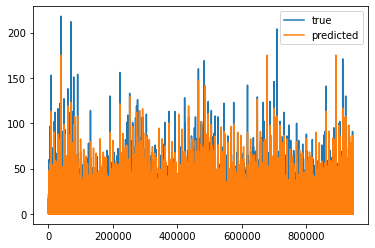

In [0]:
plt.plot(test_y, label="true")
plt.plot(rf_pred_test, label="predicted")

plt.legend()
plt.show()

In [0]:
rf.feature_importances_

array([0.02775385, 0.02038977, 0.10151449, 0.06810297, 0.03761863,
       0.02461519, 0.0049768 , 0.00329328, 0.        , 0.        ,
       0.00540635, 0.00557357, 0.00795484, 0.19753638, 0.11909089,
       0.37617298])

In [0]:
import matplotlib.pyplot as plt
from sklearn import tree


In [0]:
from sklearn.tree import export_graphviz

export_graphviz(tree_in_forest,
                feature_names=X.columns,
                filled=True,
                rounded=True)

3

## XGBoost

In [0]:
from xgboost import XGBRegressor

In [0]:
xgb = XGBRegressor(max_depth = 10, 
                   n_jobs = -1, 
                   random_state = 4211,
                   n_estimator = 50,
                   verbose = 1
                   )

In [0]:
xgb.fit(train_X, train_y)

[07:49:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:49:58] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimator=50,
             n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=4211, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbose=1, verbosity=1)

In [0]:
train_pred_y = xgb.predict(train_X)
test_pred_y = xgb.predict(test_X)

In [0]:
print(mean_squared_error(train_y, train_pred_y))
print(mean_squared_error(test_y, test_pred_y))

11.389151697758551
11.785555539603152


In [0]:
pred_train_y = xgb.predict(train_y)

In [0]:
mean_squared_error(train_y, pred_train_y)

In [0]:
xgb.feature_importances_

array([0.15873684, 0.17852134, 0.13834764, 0.0905055 , 0.10844084,
       0.02069277, 0.03583869, 0.0119386 , 0.00430612, 0.        ,
       0.        , 0.00875445, 0.00892411, 0.03249833, 0.20249492],
      dtype=float32)

## Lightlgb


In [0]:
import lightgbm as lgb

In [0]:
lgb_train = lgb.Dataset(train_X.drop(columns=['item_id']), train_y)
lgb_test = lgb.Dataset(test_X.drop(columns=['item_id']), test_y)

In [0]:
bst_params = {
    "boosting_type": "gbdt",
    "metric": "rmse",
    "objective": "regression",
    "n_jobs": -1,
    "seed": 4211,
    "learning_rate": 0.1,
    "bagging_fraction": 0.75,
    "bagging_freq": 10,
    "colsample_bytree": 0.75,
}

fit_params = {
    "num_boost_round": 100_000,
    "early_stopping_rounds": 200,
    "verbose_eval": 100,
}

In [0]:
lgb_regressor = lgb.train(bst_params, lgb_train, valid_sets=[lgb_train, lgb_test], valid_names=["train", "valid"], **fit_params)

Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 2.77641	valid's rmse: 2.86581
[200]	train's rmse: 2.65148	valid's rmse: 2.73777
[300]	train's rmse: 2.57866	valid's rmse: 2.67036
[400]	train's rmse: 2.529	valid's rmse: 2.62909
[500]	train's rmse: 2.47637	valid's rmse: 2.5763
[600]	train's rmse: 2.43411	valid's rmse: 2.53918
[700]	train's rmse: 2.40952	valid's rmse: 2.51591
[800]	train's rmse: 2.38745	valid's rmse: 2.49609
[900]	train's rmse: 2.3648	valid's rmse: 2.47792
[1000]	train's rmse: 2.34849	valid's rmse: 2.46115
[1100]	train's rmse: 2.33378	valid's rmse: 2.45125
[1200]	train's rmse: 2.31928	valid's rmse: 2.43883
[1300]	train's rmse: 2.308	valid's rmse: 2.43014
[1400]	train's rmse: 2.29547	valid's rmse: 2.42074
[1500]	train's rmse: 2.28444	valid's rmse: 2.41172
[1600]	train's rmse: 2.27685	valid's rmse: 2.40687
[1700]	train's rmse: 2.26653	valid's rmse: 2.39984
[1800]	train's rmse: 2.25736	valid's rmse: 2.39467
[1900]	train's rmse: 2.24945	valid

In [0]:
lg_pred_train = lgb_regressor.predict(train_X.drop(columns=['item_id']))
lg_pred_test = lgb_regressor.predict(test_X.drop(columns=['item_id']))

In [0]:
print(mean_squared_error(train_y, lg_pred_train))
print(mean_squared_error(test_y, lg_pred_test))

4.079638344945075
5.179346136576904


# Submission

In [0]:
valid

,item_id,dept_id,cat_id,store_id,state_id,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,demand,day_int,item_id_int
10397090,HOBBIES_1_001,1,2,1,1,3,4,31,5,2,2,0,0,0,8.38,0.0,1914,1
10397091,HOBBIES_1_002,1,2,1,1,3,4,31,5,2,2,0,0,0,3.97,0.0,1914,2
10397092,HOBBIES_1_003,1,2,1,1,3,4,31,5,2,2,0,0,0,2.97,0.0,1914,3
10397093,HOBBIES_1_004,1,2,1,1,3,4,31,5,2,2,0,0,0,4.64,0.0,1914,4
10397094,HOBBIES_1_005,1,2,1,1,3,4,31,5,2,2,0,0,0,2.88,0.0,1914,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11250805,FOODS_3_823,3,1,3,3,2,5,31,5,2,2,0,0,0,2.98,0.0,1941,823
11250806,FOODS_3_824,3,1,3,3,2,5,31,5,2,2,0,0,0,2.48,0.0,1941,824
11250807,FOODS_3_825,3,1,3,3,2,5,31,5,2,2,0,0,0,3.98,0.0,1941,825
11250808,FOODS_3_826,3,1,3,3,2,5,31,5,2,2,0,0,0,1.28,0.0,1941,826


In [0]:
valid_pred = rf.predict(valid.drop(columns=['item_id', 'demand']))

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    1.4s finished


In [0]:
rf.feature_importances_

array([0.02775385, 0.02038977, 0.10151449, 0.06810297, 0.03761863,
       0.02461519, 0.0049768 , 0.00329328, 0.        , 0.        ,
       0.00540635, 0.00557357, 0.00795484, 0.19753638, 0.11909089,
       0.37617298])

In [0]:
valid['demand'] = valid_pred

In [0]:
valid['state_id'] = valid['state_id'].astype(str).map({'1':'CA', '2':'TX', '3':'WI'})

In [0]:
(valid['item_id'] + '_' + valid['state_id'].astype(str) + '_' + valid['store_id'].astype(str) + '_validation')

10397090    HOBBIES_1_001_CA_1_validation
10397091    HOBBIES_1_002_CA_1_validation
10397092    HOBBIES_1_003_CA_1_validation
10397093    HOBBIES_1_004_CA_1_validation
10397094    HOBBIES_1_005_CA_1_validation
                        ...              
11250805      FOODS_3_823_WI_3_validation
11250806      FOODS_3_824_WI_3_validation
11250807      FOODS_3_825_WI_3_validation
11250808      FOODS_3_826_WI_3_validation
11250809      FOODS_3_827_WI_3_validation
Length: 853720, dtype: object

In [0]:
valid['item_id'] = (valid['item_id'] + '_' + valid['state_id'].astype(str) + '_' + valid['store_id'].astype(str) + '_validation')

In [0]:
valid

,item_id,dept_id,cat_id,store_id,state_id,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,demand,day_int,item_id_int
10397090,HOBBIES_1_001_CA_1_validation,1,2,1,CA,3,4,31,5,2,2,0,0,0,8.38,1.667409,1914,1
10397091,HOBBIES_1_002_CA_1_validation,1,2,1,CA,3,4,31,5,2,2,0,0,0,3.97,0.203490,1914,2
10397092,HOBBIES_1_003_CA_1_validation,1,2,1,CA,3,4,31,5,2,2,0,0,0,2.97,0.121611,1914,3
10397093,HOBBIES_1_004_CA_1_validation,1,2,1,CA,3,4,31,5,2,2,0,0,0,4.64,3.067122,1914,4
10397094,HOBBIES_1_005_CA_1_validation,1,2,1,CA,3,4,31,5,2,2,0,0,0,2.88,1.693130,1914,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11250805,FOODS_3_823_WI_3_validation,3,1,3,WI,2,5,31,5,2,2,0,0,0,2.98,1.864426,1941,823
11250806,FOODS_3_824_WI_3_validation,3,1,3,WI,2,5,31,5,2,2,0,0,0,2.48,0.563325,1941,824
11250807,FOODS_3_825_WI_3_validation,3,1,3,WI,2,5,31,5,2,2,0,0,0,3.98,1.202803,1941,825
11250808,FOODS_3_826_WI_3_validation,3,1,3,WI,2,5,31,5,2,2,0,0,0,1.28,1.167270,1941,826


In [0]:
valid_df = pd.pivot_table(valid, values=['demand'], index=['item_id'], columns=['day_int'])

In [0]:
evalue_pred = rf.predict(evalue.drop(columns=['item_id', 'demand']))

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    1.0s finished


In [0]:
evalue['demand'] = evalue_pred

In [0]:
evalue['state_id'] = evalue['state_id'].astype(str).map({'1':'CA', '2':'TX', '3':'WI'})
evalue['item_id'] = (evalue['item_id'] + '_' + evalue['state_id'].astype(str) + '_' + evalue['store_id'].astype(str) + '_validation')
evalue

,item_id,dept_id,cat_id,store_id,state_id,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,demand,day_int,item_id_int
11250810,HOBBIES_1_001_CA_1_validation,1,2,1,CA,3,5,31,5,2,2,0,0,0,8.38,1.667409,1942,1
11250811,HOBBIES_1_002_CA_1_validation,1,2,1,CA,3,5,31,5,2,2,0,0,0,3.97,0.203490,1942,2
11250812,HOBBIES_1_003_CA_1_validation,1,2,1,CA,3,5,31,5,2,2,0,0,0,2.97,0.126611,1942,3
11250813,HOBBIES_1_004_CA_1_validation,1,2,1,CA,3,5,31,5,2,2,0,0,0,4.64,3.020455,1942,4
11250814,HOBBIES_1_005_CA_1_validation,1,2,1,CA,3,5,31,5,2,2,0,0,0,2.88,1.693130,1942,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12104525,FOODS_3_823_WI_3_validation,3,1,3,WI,2,6,17,4,1,1,0,0,0,2.98,1.864426,1969,823
12104526,FOODS_3_824_WI_3_validation,3,1,3,WI,2,6,17,4,1,1,0,0,0,2.48,0.572679,1969,824
12104527,FOODS_3_825_WI_3_validation,3,1,3,WI,2,6,17,4,1,1,0,0,0,3.98,1.202803,1969,825
12104528,FOODS_3_826_WI_3_validation,3,1,3,WI,2,6,17,4,1,1,0,0,0,1.28,1.065480,1969,826


In [0]:
evalue['item_id'] = evalue['item_id'].str.slice(stop=-10) + 'evaluation'

In [0]:
eval_df = pd.pivot_table(evalue, values=['demand'], index=['item_id'], columns=['day_int'])

## Concat

In [0]:
eval_df.reset_index(inplace=True)

In [0]:
eval_df.columns = ['id'] + ['F' + str(i) for i in np.arange(1, 29, 1)]

In [0]:
eval_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.867162,0.860378,0.860378,0.858334,0.858334,1.156300,1.150965,0.867162,0.860378,0.860378,0.863996,0.863996,1.158980,1.188851,0.872824,0.860378,0.866040,0.863996,0.858334,1.219255,1.186171,0.867162,0.866040,0.866040,0.858334,0.858334,1.156300,1.134961
1,FOODS_1_001_CA_2_evaluation,0.847819,0.847819,0.847819,0.843397,0.843397,1.394829,1.394829,0.857305,0.847819,0.856643,0.869142,0.869142,1.394829,1.394829,0.873564,0.856643,0.873564,0.869142,0.852221,1.394829,1.394829,0.856643,0.873564,0.873564,0.852221,0.852221,1.394829,1.461405
2,FOODS_1_001_CA_3_evaluation,1.058580,1.047436,1.047436,1.059837,1.059837,1.418114,1.418114,1.093594,1.047436,1.075079,1.088532,1.121472,1.418114,1.418114,1.092706,1.071034,1.056969,1.121472,1.062888,1.418114,1.418114,1.086224,1.056969,1.081562,1.062888,1.062888,1.418114,1.430793
3,FOODS_1_001_CA_4_evaluation,0.540895,0.540895,0.540895,0.540895,0.548961,0.537625,0.533625,0.530895,0.540895,0.542792,0.532792,0.547471,0.539521,0.535521,0.542792,0.532792,0.542792,0.542792,0.547471,0.539521,0.535521,0.542792,0.542792,0.542792,0.542792,0.550858,0.539521,0.535521
4,FOODS_1_001_TX_1_evaluation,0.426777,0.426777,0.426777,0.426777,0.426777,0.434841,0.434841,0.426777,0.426777,0.428249,0.431907,0.431907,0.436313,0.438816,0.431907,0.428249,0.431907,0.431907,0.428249,0.437344,0.437344,0.426777,0.430435,0.430435,0.426777,0.426777,0.434841,0.434841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.235746,0.218106,0.232671,0.255633,0.313063,0.388395,0.240731,0.258041,0.218106,0.208055,0.245091,0.279430,0.376968,0.253848,0.200813,0.230612,0.195368,0.222000,0.284777,0.395288,0.259887,0.232921,0.204108,0.225895,0.255633,0.313063,0.388026,0.268874
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.160512,0.142930,0.151938,0.174137,0.181694,0.300476,0.272065,0.211574,0.142930,0.167419,0.208315,0.184754,0.301012,0.310504,0.141980,0.166538,0.138282,0.177198,0.182451,0.317671,0.295279,0.159736,0.128532,0.146813,0.174137,0.181694,0.300107,0.284057
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.083333,0.090118,0.086986,0.081617,0.099720,0.549056,0.290239,0.083333,0.090118,0.182164,0.090346,0.122831,0.546973,0.316220,0.091297,0.188095,0.097480,0.103103,0.134813,0.502998,0.316220,0.108439,0.089358,0.091423,0.077430,0.098706,0.539056,0.256787
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.023639,0.022111,0.022476,0.049486,0.069207,0.038152,0.028679,0.015937,0.022111,0.081397,0.161265,0.160533,0.059746,0.085797,0.107034,0.073247,0.118374,0.141114,0.169410,0.084307,0.077441,0.026916,0.052214,0.037528,0.049486,0.069207,0.038152,0.025178


In [0]:
valid_df.reset_index(inplace=True)
valid_df.columns = ['id'] + ['F' + str(i) for i in np.arange(1, 29, 1)]

In [0]:
valid_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.867162,0.860378,0.860378,0.858334,0.858334,1.140296,1.149007,0.872824,0.866040,0.860378,0.876358,0.863996,1.178013,1.161481,0.872824,0.860378,0.866040,0.863996,0.858334,1.200222,1.186171,0.867162,0.860378,0.860378,0.858334,0.858334,1.156300,1.150965
1,FOODS_1_001_CA_2_validation,0.847819,0.847819,0.847819,0.843397,0.843397,1.394829,1.394829,0.864740,0.864740,0.847819,0.852978,0.860318,1.394829,1.473751,0.864740,0.847819,0.864740,0.860318,0.843397,1.394829,1.394829,0.847819,0.847819,0.847819,0.843397,0.843397,1.394829,1.394829
2,FOODS_1_001_CA_3_validation,1.058580,1.047436,1.047436,1.059837,1.059837,1.418114,1.418114,1.065063,1.078511,1.047436,1.146023,1.118421,1.418114,1.443139,1.089655,1.047436,1.078511,1.118421,1.084429,1.418114,1.418114,1.058580,1.047436,1.047436,1.059837,1.059837,1.418114,1.418114
3,FOODS_1_001_CA_4_validation,0.540895,0.540895,0.540895,0.540895,0.548961,0.537625,0.533625,0.540895,0.540895,0.540895,0.530895,0.545574,0.537625,0.533625,0.540895,0.540895,0.540895,0.540895,0.548961,0.537625,0.533625,0.540895,0.540895,0.540895,0.540895,0.548961,0.537625,0.533625
4,FOODS_1_001_TX_1_validation,0.426777,0.426777,0.426777,0.426777,0.426777,0.434841,0.436313,0.431907,0.431907,0.428249,0.431907,0.431907,0.436313,0.438816,0.431907,0.428249,0.430435,0.430435,0.426777,0.437344,0.437344,0.426777,0.426777,0.426777,0.426777,0.426777,0.434841,0.434841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.235746,0.218106,0.232671,0.255633,0.313063,0.386395,0.246413,0.203638,0.194308,0.204385,0.292431,0.279430,0.379356,0.291260,0.200813,0.201208,0.225895,0.248858,0.316733,0.397250,0.260868,0.235746,0.218106,0.232671,0.255633,0.313063,0.388395,0.240731
30486,HOUSEHOLD_2_516_TX_3_validation,0.160512,0.142930,0.151938,0.174137,0.181694,0.298476,0.297360,0.142755,0.132974,0.151699,0.274287,0.184754,1.796662,1.538322,1.546829,1.469816,1.439790,1.365244,1.460163,0.308748,0.296260,0.160512,0.142930,0.151938,0.174137,0.181694,0.300476,0.272065
30487,HOUSEHOLD_2_516_WI_1_validation,0.083333,0.090118,0.086986,0.081617,0.099720,0.535604,0.323704,0.087882,0.094702,0.154657,0.102926,0.120646,0.561033,0.251767,0.087916,0.149088,0.091089,0.112757,0.126500,0.498938,0.326220,0.083333,0.090118,0.086986,0.081617,0.099720,0.549056,0.290239
30488,HOUSEHOLD_2_516_WI_2_validation,0.023639,0.022111,0.022476,0.049486,0.069207,0.031105,0.055686,0.127031,0.098089,0.093729,0.138316,0.160533,0.066733,0.091420,0.107034,0.093364,0.037528,0.045895,0.061268,0.077914,0.077441,0.023639,0.022111,0.022476,0.049486,0.069207,0.038152,0.028679


In [0]:
submission.columns

Index(['id', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10',
       'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20',
       'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28'],
      dtype='object')

In [0]:
sub_df = pd.concat([valid_df, eval_df])

In [0]:
sub_df = pd.merge(submission[['id']], sub_df, on='id')

In [0]:
sub_df.to_csv("submission.csv", index=False)